In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import sys
import os
sys.path.append(os.path.abspath("../scripts"))
try:
    from eda import ExplanatoryAnalysis
except:
    print("import error")

import error


In [4]:
df_bnd = pd.read_csv('/content/drive/MyDrive/week11/BND_raw_data.csv')
df_spy = pd.read_csv('/content/drive/MyDrive/week11/SPY_raw_data.csv')
df_tsla = pd.read_csv('/content/drive/MyDrive/week11/TSLA_raw_data.csv')

In [ ]:
bnd_eda = ExplanatoryAnalysis()
spy_eda = ExplanatoryAnalysis()
tsla_eda = ExplanatoryAnalysis()
df_bnd=bnd_eda.to_time(df_bnd, "BND")
df_spy=spy_eda.to_time(df_spy, "SPY")
df_tsla=tsla_eda.to_time(df_tsla, "TSLA")

In [5]:
def to_time(df):
  df['Date'] = pd.to_datetime(df['Date'])
  df.set_index('Date', inplace=True)
  return df

In [7]:
df_bnd=to_time(df_bnd)
df_spy=to_time(df_spy)
df_tsla=to_time(df_tsla)

In [8]:
df_tsla.head()

,Close_TSLA,High_TSLA,Low_TSLA,Open_TSLA,Volume_TSLA
Date,,,,,
2015-01-02,14.620667,14.883333,14.217333,14.858000,71466000
2015-01-05,14.006000,14.433333,13.810667,14.303333,80527500
2015-01-06,14.085333,14.280000,13.614000,14.004000,93928500
2015-01-07,14.063333,14.318667,13.985333,14.223333,44526000
2015-01-08,14.041333,14.253333,14.000667,14.187333,51637500


In [9]:
train_size = int(0.8* len(df_tsla))
train_size

2028

In [10]:
df_tsla['Close_TSLA_Diff'] = df_tsla['Close_TSLA'].diff().dropna()
last_close = df_tsla['Close_TSLA'][train_size-1]

<ipython-input-10-85f6c5ec535e>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  last_close = df_tsla['Close_TSLA'][train_size-1]


In [11]:
# Train ARIMA on the differenced series
train_data = df_tsla["Close_TSLA_Diff"][:train_size]
test_data = df_tsla[["Close_TSLA"]][train_size:train_size+30]

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

In [13]:
# Select closing price & normalize it
scaler = MinMaxScaler(feature_range=(0,1))
df_tsla["Close_scaled"] = scaler.fit_transform(df_tsla[["Close_TSLA"]])

# Define lookback period (e.g., 60 days)
timesteps = 60

# Prepare training data
X_train, y_train = [], []
for i in range(timesteps, len(df_tsla) - 30):  # Reserve last 30 days for forecasting
    X_train.append(df_tsla["Close_scaled"].values[i-timesteps:i])
    y_train.append(df_tsla["Close_scaled"].values[i])

X_train, y_train = np.array(X_train), np.array(y_train)




In [15]:
# Build LSTM model
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(units=30, return_sequences=True),
    Dropout(0.1),
    LSTM(units=15, return_sequences=False),
    Dense(units=1)
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss="mean_squared_error")

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32)


Epoch 1/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - loss: 0.0159
Epoch 2/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0016
Epoch 3/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 9.8684e-04
Epoch 4/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 8.2428e-04
Epoch 5/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 8.2928e-04
Epoch 6/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 7.4483e-04
Epoch 7/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 7.8794e-04
Epoch 8/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 5.6829e-04
Epoch 9/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 5.4065e-04
Epoch 10/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - loss: 7.3424e-04
Epoch 11/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 6.6731e-04
Epoch 12/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - loss: 4.9551e-04
Epoch 13/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 7.2368e-04
Epoch 14/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 5.9170e-04
Epoch 15/50
77/77 ━━━━━

In [16]:
# Prepare test data (last `timesteps` days)
test_df = df_tsla["Close_scaled"].values[-timesteps:].reshape(1, timesteps, 1)


In [17]:
x_test =test_df[0,:,]
y_test =df_tsla["Close_scaled"][-60:].values

In [18]:
loss = model.evaluate(x_test, y_test)
loss = scaler.inverse_transform([[loss]])
loss

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0147 


array([[17.08400473]])

In [19]:
joblib.dump(model, 'lstm_model_loss(15).joblib')

['lstm_model_loss(15).joblib']

In [20]:
# Initialize input with last 60 days of actual data
test_input = df_tsla["Close_TSLA"].values[-60:]
test_input = scaler.transform(test_input.reshape(-1, 1)).reshape(1, 60, 1)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [22]:


forecast = []

for _ in range(180):  # Predict next 60 days
    pred = model.predict(test_input[0])  # Predict one day ahead
    forecast.append(pred[0, 0])  # Store prediction

    # Update input by appending the new prediction & removing the first value
    test_input = np.append(test_input[:, 1:, :], pred[0,0].reshape(1, 1, 1), axis=1)

# Convert predictions back to original scale
forecast_prices = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━

In [23]:
forecast_dates = pd.date_range(start="2025-02-01", periods=180, freq="D")


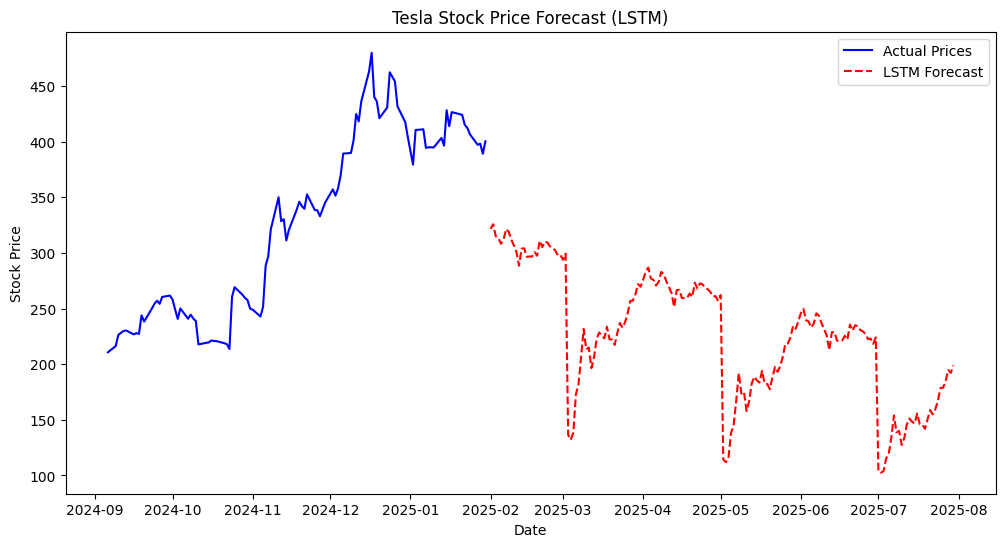

In [24]:
plt.figure(figsize=(12, 6))

# Plot actual prices (last 100 days before forecast)
plt.plot(df_tsla.index[-100:], df_tsla["Close_TSLA"].values[-100:], label="Actual Prices", color="blue")

# Plot forecasted prices
plt.plot(forecast_dates, forecast_prices, label="LSTM Forecast", color="red", linestyle="dashed")

plt.title("Tesla Stock Price Forecast (LSTM)")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()


In [25]:
# Compute residual errors from past predictions
past_predictions = model.predict(X_train)  # Predictions on training data
errors = y_train - past_predictions.flatten()  # Compute residuals

# Compute standard deviation of errors
error_std = np.std(errors)
Z_50 = 0.674  # Z-score for 50% confidence interval

upper_bound = forecast_prices + (Z_50 * error_std)
lower_bound = forecast_prices - (Z_50 * error_std)

# Ensure lower bound does not go below zero (stock prices cannot be negative)
lower_bound = np.maximum(lower_bound, 0)


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step


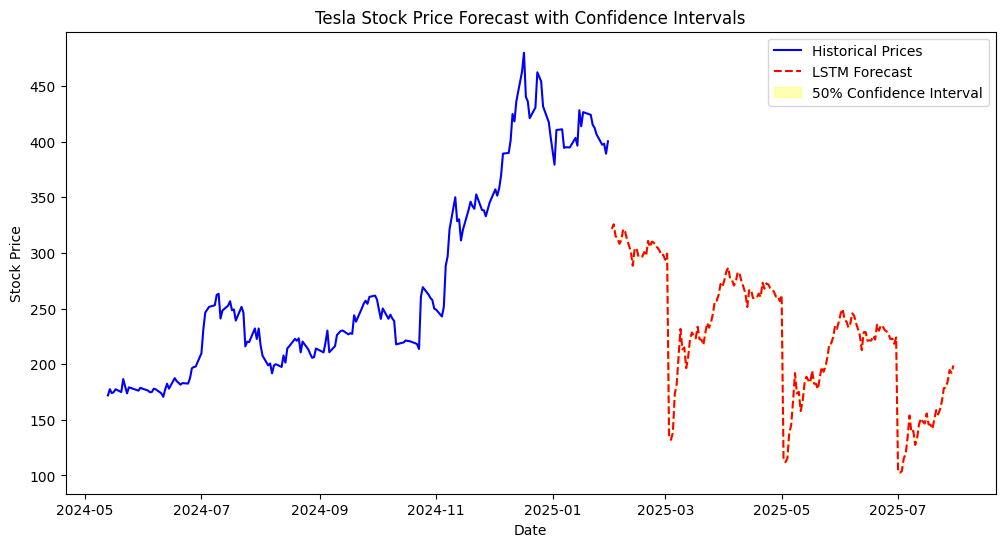

In [30]:
plt.figure(figsize=(12, 6))

# Plot historical data
plt.plot(df_tsla.index[-180:], df_tsla["Close_TSLA"].values[-180:], label="Historical Prices", color="blue")

# Plot forecast with confidence interval
plt.plot(forecast_dates, forecast_prices, label="LSTM Forecast", color="red", linestyle="dashed")
plt.fill_between(forecast_dates, lower_bound.flatten(), upper_bound.flatten(), color="yellow", alpha=0.3, label="50% Confidence Interval")

plt.title("Tesla Stock Price Forecast with Confidence Intervals")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()
